## Import libraries

In [ ]:
import os
import math
import json
import folium
import pickle
import warnings
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
from scipy import stats
from vega_datasets import data
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from numpy import cos, sin, arcsin, sqrt
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
warnings.simplefilter(action='ignore', category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plt.figure(figsize=(20,5))

TG_ID = os.environ['TG_ID']
TG_TOKEN = os.environ['TG_TOKEN']

PALETTE_DEG = ["FF"]
PALETTE = ["#FFC30D", "#EF404B"]
PALETTE_ALT = ["#40EFE4", "#EF404B"]

R = 6371
KMS_AROUND = 3.20
WINDOW_TIME = 3.12

In [ ]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')

## Utils functions

In [ ]:
def set_labels(title=None, x_label=None, y_label=None, fontsize=14, legend=None):
  if title is not None:
    plt.title(title, fontsize=fontsize)
  if x_label is not None:
    plt.xlabel(x_label, fontsize=fontsize)
  if y_label is not None:
    plt.ylabel(y_label, fontsize=fontsize)
  if legend is not None:
    legend['object'].set_title(legend['title'])
    for t, l in zip(legend['object'].texts, legend['texts']): t.set_text(l)

def with_hue(plot, feature, categories, hue_categories, diff=False):
  a = [p.get_height() for p in plot.patches]
  patch = [p for p in plot.patches]
  differences = {'class': [], 'value': []}
  for i in range(categories):
    total = a[i] + a[i+categories]
    difference = []
    for j in range(hue_categories):
      value = round(100 * a[(j*categories + i)]/total, 2)
      percentage = '{:.1f}%'.format(value)
      x = patch[(j*categories + i)].get_x() + patch[(j*categories + i)].get_width() / 2 - 0.15
      y = patch[(j*categories + i)].get_y() + patch[(j*categories + i)].get_height() 
      plt.annotate(percentage, (x, y), size = 12)
      if diff:
        difference.append(value)
    if diff:
      diff_value = abs(round(difference[0]-difference[1], 2))
      differences['class'].append(feature[i])
      differences['value'].append(diff_value)
      print('{0:16s}: |{1:>5} - {2:>5}| = {3:>5}'.format(feature[i], difference[0], difference[1], diff_value))
    #print(f'{feature[i]}: {difference[0]} - {difference[1]} = {abs(round(difference[0]-difference[1], 2))}')
  plt.show()
  if diff:
    return pd.DataFrame.from_dict(differences)
  
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

## Enmanuel Magallanes

## Question: Is the total size of packages a factor affecting the timeliness of deliveries?

In [ ]:
#dict of size
size_dict = { 1: 'X Small', 2: 'Small', 3: 'Medium', 4: 'Large', 5: 'X Large' }

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='total_size', order=size_dict.values(), palette=PALETTE)
set_labels('Frecuencia de los tipos de peso', 'Tipo de peso', 'Frecuencia')

In [ ]:
df.columns

In [ ]:
data
data.total_size = data.total_size.astype('category').cat.codes
data

In [ ]:
brush = alt.selection(type='interval', encodings=['x'])
color_scale = alt.Scale(domain=list(size_dict.values()))

base = alt.Chart(data).mark_bar().encode(
  x=alt.X(alt.repeat('column'), type='quantitative', bin=alt.Bin(maxbins=40)), y='count()',
  color=alt.Color('total_size:N', legend=alt.Legend(title='Total size'), scale=color_scale),
).properties(width=380, height=250)
background = base.encode(color=alt.value('#ddd')).add_selection(brush)

highlight = base.transform_filter(brush)
columns = ['total_size', 'distance', 'task_around']
data = df.sample(5000)[columns]
alt.layer(background, highlight, data=data).repeat(column=columns[1:])

In [ ]:
gsl = df[['id', 'total_size', 'is_late']].groupby(['total_size', 'is_late'])['id'].count().reset_index()
plt.figure(figsize=(12,7))
plt.tight_layout()
f = sns.barplot(data=gsl, x='total_size', y='id', hue='is_late', order=size_dict.values(), palette=PALETTE_ALT)

set_labels(
  'Amount of tasks per type of size', 'Type of size', 'Amount of tasks', 
  legend={'object': f.get_legend(), 'title': 'Delivery time', 'texts': ['Not Late', 'Late']
})
diff_size = with_hue(f, list(size_dict.values()), 5, 2, diff=True)

In the graph we can see that there are more deliveries with size X Small and Medium than the others. However, what is important here is to analyze the percentage of tasks delivered on time and those that are not. There are no significant differences between Small and Small X-size tasks. In contrast, Medium, Large and X Large tasks have a significant difference in the percentage of on-time deliveries. This indicates that the size of deliverables affects on-time delivery when their size is equal to or larger than Medium.

In [ ]:
plt.figure(figsize=(12,8))
plt.tight_layout()
sns.barplot(data=diff_size, x='class', y='value')
set_labels(
  title='Difference between the percentage of deliveries late minus not late deliveries\nclassified by total size of delivery',
  x_label='Class of size of deliveries', y_label='Amount of deliveries'
)

## Question 2: Are tasks with fewer neighboring deliveries* taking longer to reach their delivery point?
\* We define neighboring deliveries as all those deliveries that are less than or equal to X KM away from the same and their delivery date is within T hours of the same.

In [ ]:
# We will group deliveries by route ID, to get the average distance and time from the first delivery to the last delivery. 
# With these values we will obtain distance and time ranges to find the route density.
def haversine_distance(x, y):
  lon1, lat1, lon2, lat2 = map(math.radians, [x[0], x[1], y[0], y[1]])
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
  c = 2 * math.asin(sqrt(a))
  return R * c

def generate_combinations(points):
  combinations = []
  for i in range(len(points)):
    for j in range(i+1, len(points)):
      combinations.append([points[i], points[j]])
  return combinations

def calculate_time(group):
  min_dt = group['delivery_dt'].min()
  max_dt = group['delivery_dt'].max()
  return (max_dt - min_dt).total_seconds() / 3600

def calculate_distance(group):
  group = group.set_index('delivery_dt')
  group = group.sort_values('delivery_dt')
  center = (group['long'].mean(), group['lat'].mean())
  return np.array(group.apply(lambda r: haversine_distance((r.long, r.lat), center), axis=1)).mean()

gr_hours = df.groupby('route_id').apply(calculate_time)
gr_distance = df.groupby('route_id').apply(calculate_distance)

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of time from first to last delivery')
ax[0].set_xlabel('Time (hour)')
sns.kdeplot(data=gr_distance, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of time from first to last delivery')
ax[1].set_xlabel('Time (hour)')
sns.boxenplot(data=gr_distance, ax=ax[1], color=PALETTE[1])

print('Mean time from first delivery to the last delivery: {0:.2f} hours'.format(gr_hours.mean()))

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of distance from first to last delivery')
ax[0].set_xlabel('Distnace (km)')
sns.kdeplot(data=gr_hours, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of distance from first to last delivery')
ax[1].set_xlabel('Distnace (km)')
sns.boxenplot(data=gr_hours, ax=ax[1], color=PALETTE[1])
print('Mean distance first delivery to the last delivery: {0:.2f} km'.format(gr_distance.mean()))

As we can see the scheduled time from the first delivery to the last delivery, on average, is 3.12 hours and the distance, on average, is 3.20 km. These values will be our time window and radius to use to determine the number of deliveries that exist around one

In [ ]:
df['class_neighboring'] = pd.cut(
  df['task_around'], 
  include_lowest=True,
  bins=[x for x in range(0, 800, 100)]
)
#df_filtered['class_neighboring'] = df_filtered['class_neighboring'].astype('str')

In [ ]:
# Remoiving outlayers using the z-score
z_scores = stats.zscore(df['task_around'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 3
df_filtered = df[ filtered_entries ]
task_around_filtered = df[ filtered_entries ]['task_around']

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of neighboring deliveries')
ax[0].set_xlabel('Neighboring deliveries')
sns.kdeplot(data=df_filtered['task_around'], ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of neighboring deliveries')
ax[1].set_xlabel('Neighboring deliveries')
sns.boxenplot(data=task_around_filtered, ax=ax[1], color=PALETTE[1])

print('Mean neighboring deliveries: {0:.2f} deliveries'.format(task_around_filtered.mean()))
print('STD neighboring deliveries: {0:.2f}'.format(task_around_filtered.std()))

In [ ]:
gnl = df_filtered[['id', 'class_neighboring', 'is_late']].groupby(['class_neighboring', 'is_late'])['id'].count().reset_index()
plt.figure(figsize=(12,7))
plt.tight_layout()
f = sns.barplot(data=gnl, x='class_neighboring', y='id', hue='is_late', palette=PALETTE_ALT)

set_labels(
  'Amount of tasks per class of neighboring deliverie', 'Bind of neighboring deliveries', 'Amount of deliveries', 
  legend={'object': f.get_legend(), 'title': 'Delivery time', 'texts': ['Not Late', 'Late']
})
classes_list = list(map(lambda item: str(item), df_filtered['class_neighboring'].sort_values().unique()))
diff_list = with_hue(f, classes_list, 7, 2, diff=True)

In the plot we can see that as the number of neighboring deliveries increases, the percentage of late deliveries also increases. This tells us that the higher the concentration or density of deliveries around you, the more likely it is that you will be late in reaching the final customer

In [ ]:
columns = ['total_size', 'distance', 'task_around', 'lat', 'long']
data = df.sample(5000)[columns]
# interval selection in the scatter plot
pts = alt.selection(type="interval", encodings=["x"])

# left panel: scatter plot
points = alt.Chart().mark_point(
  filled=True, color=PALETTE_ALT[1],
).encode(
  #x='lat:Q', y='long:Q'
  x=alt.X('lat', type='quantitative', scale=alt.Scale(domain=(-33.70, -33.15))),
  y=alt.Y('long',type='quantitative', scale=alt.Scale(domain=(-70.4, -70.9))),
).transform_filter(pts).properties(width=600, height=300)

# right panel: histogram
mag = alt.Chart().mark_bar().encode(
  x='task_around:N', y='count()',
  #color=alt.condition(pts, alt.value(PALETTE_ALT[1]), alt.value("lightgray"))
  color=alt.Color('total_size:N', legend=alt.Legend(title='Total size'), scale=color_scale),
).properties(width=300, height=300).add_selection(pts)

alt.hconcat(points, mag, data=data[columns]).transform_bin(
    "task_around",
    field="task_around",
    bin=alt.Bin(maxbins=40)
)

In [ ]:
plt.figure(figsize=(12,8))
plt.tight_layout()
sns.barplot(data=diff_list, x='class', y='value')
set_labels(
  title='Difference between the percentage of deliveries late minus not late deliveries\nclassified by number of neighboring deliveries',
  x_label='Class of amount of neighboring deliveries', y_label='Amount of deliveries'
)

## Ploting location of task with low and hight neighboring deliveries 

In [ ]:
diff = df['delivery'] - df['delivery_effective']
df['delay_delivery'] = diff.apply(lambda x: abs(int(x.total_seconds()))) / 3600

In [ ]:
def get_color(tasks):
  """Get color for task"""
  if tasks == 0:
    return 'black'
  elif 0 <= tasks < 300:
    return 'blue'
  elif 300 <= tasks < 1000:
    return 'red'

def add_marker(row, map_stg):
  folium.Marker(
    location=[row['lat'], row['long']],
    popup=row['id'],
    icon=folium.Icon(color=get_color(row['task_around']))
  ).add_to(map_stg)

stg_map = folium.Map(location=[-33.469477, -70.643929], zoom_start=12)
a = df \
[['lat', 'long', 'id', 'class_neighboring', 'task_around']].sample(100).apply(
  lambda r: add_marker(r, stg_map), axis=1
)
#[ (df['task_around']>=400) & (df['task_around']<800) ] \
#stg_map

## Clustering (KMeans)

In [ ]:
RAMDOM_SEED = 2048

features = [
  'total_size', 'distance', 'delivery_type',
  'lat', 'long', 'task_around',
  'city', 'cost', 'delta'
  #'pickup_effective_dt', 'delivery_dt'
]
stad_dist = ['lat', 'long']
stad_cols = [
  'total_size', 'distance','task_around', 'cost', 'delivery_type', 'delta'
]
stad_dt = ['delivery_dt', 'pickup_effective_dt']

In [263]:
df['delta'] = (df.delivery_dt - df.delivery_effective).dt.total_seconds() / 3600

In [264]:

dff = df.copy()
dff['delta'] = (dff.delivery_dt - dff.delivery_effective).dt.total_seconds() / 3600
dff.delivery_dt = dff.delivery_dt.view('i8')
dff.delivery_effective = dff.delivery_effective.view('i8')
dff.pickup_effective_dt = dff.pickup_effective_dt.view('i8')

dff.total_size = dff.total_size.astype('category').cat.codes
dff.delivery_type = dff.delivery_type.astype('category').cat.codes

if True:
  scaler = MinMaxScaler(feature_range=(0, 10))
  dff[stad_cols] = scaler.fit_transform(dff[stad_cols])

  scaler_dist = MinMaxScaler(feature_range=(0, 10))
  dff[stad_dist] = scaler_dist.fit_transform(dff[stad_dist])

  scaler_dt = MinMaxScaler(feature_range=(0, 1e3)) #1e3
  dff[stad_dt] = scaler_dt.fit_transform(dff[stad_dt])

dff_features = dff[features]

In [ ]:
from sklearn.cluster import MiniBatchKMeans
model = MiniBatchKMeans(init='k-means++', random_state=RAMDOM_SEED)
try:
  visualizer = KElbowVisualizer(model, k=(2,10), timings=True)
  visualizer.fit(dff_features)
  visualizer
except:
  pass

In [ ]:
model = KMeans(n_clusters=visualizer.elbow_value_, init='k-means++', random_state=RAMDOM_SEED)
model.fit(dff_features)
y_means = model.predict(dff_features)

interDistance = InterclusterDistance(model, random_state=RAMDOM_SEED)
interDistance.fit(dff_features)
interDistance.show()
print(interDistance.scores_)

El efecto de estadarizar los features o no si cambia el comportamiento de los clusters, sin estandarizacion el grafico de distancia inter-cluster muestra un aparente overlaping estre casi todos los clusters. Si bien, este overlaping en dos dimenciones no es indicador de overlaping en las dimenciones reales, es un indicador de que la calidad de los clusters no es la mejor y que estan bastante cerca entre ellos.

Con la estadrizacion de las variables la cantidad de cluster recoemndada por Elbow method tambien cambio de 5 clusters a solo 3. Ahora, el graifco de inter-cluster distance muestra una mejora en la distribucion de los clusters los cuales estan mucho mas separados entre ellos.

In [ ]:
df['cluster'] = model.labels_

In [ ]:
plt.figure(figsize=(10,5))
plt.tight_layout()
sns.scatterplot(data=df, x='lat', y='long', hue='cluster').set(xlim=(-33.70, -33.1), ylim=(-70.4, -71))

In [265]:
for cluster in range(visualizer.elbow_value_):
  print('Cluster {} size: {}'.format(cluster, len(df[ df['cluster'] == cluster ][features])))
print(features)

Cluster 0 size: 60006
Cluster 1 size: 141231
Cluster 2 size: 25591
['total_size', 'distance', 'delivery_type', 'lat', 'long', 'task_around', 'city', 'cost', 'delta']


Text(0.5,0,'neighbording deliveries')

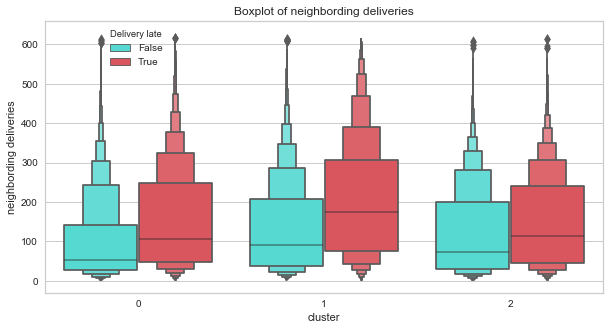

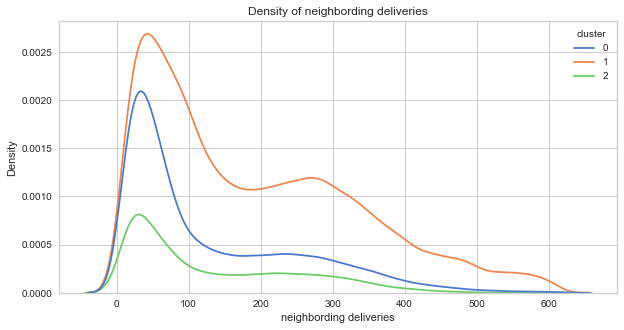

In [270]:
columns = ['total_size', 'distance', 'task_around']
cluster_0 = df[ df['cluster'] == 0 ]
z_scores = stats.zscore(df['task_around'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 3
df_ = df[ filtered_entries ]

plt.figure(figsize=(10,5))
plt.tight_layout()
gtg = sns.boxenplot(data=df_, x='cluster', y='task_around', hue='is_late', palette=PALETTE_ALT)
gtg.set_title('Boxplot of neighbording deliveries')
gtg.legend_._set_loc(2)
gtg.legend_.set_bbox_to_anchor((0.1, 1))
gtg.set_ylabel('neighbording deliveries')
gtg.legend_.set_title('Delivery late')

plt.figure(figsize=(10,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='task_around', hue='cluster', palette='muted')
gts.set_title('Density of neighbording deliveries')
gts.set_xlabel('neighbording deliveries')

In this graph is show a `boxenplot`. It is similar to a box plot in plotting a nonparametric representation of a distribution in which all features correspond to actual observations. By plotting more quantiles, it provides more information about the shape of the distribution, particularly in the tails.

En los boxplots podemos observar que, para las tareas que no estan atrasadas, el cluster 0 es el que tiene una mediana de entregas vecinas mas baja que el resto. Para las tareas atrasadas, entre el cluster 1 y 2 su mediana y distribucion tienen una forma similar. Por otro lado, para las tareas atrasadas, el cluster 0 y 2, son los que tienen la mediana mas baja, mientras que el cluster 1 es el que tiene la mediana mas alta.

En el kdeplot podemos observar que la forma de las distribuciones es banstante similar entre los clusters, sin embargo, el cluster 1 es el que tiene un densidad mas alta de entregas vecinas que el reststo. El cluster 2 es el que menos densidad de tareas vecinas presenta.

Text(0.5,1,'Density of Neighbod deliveries')

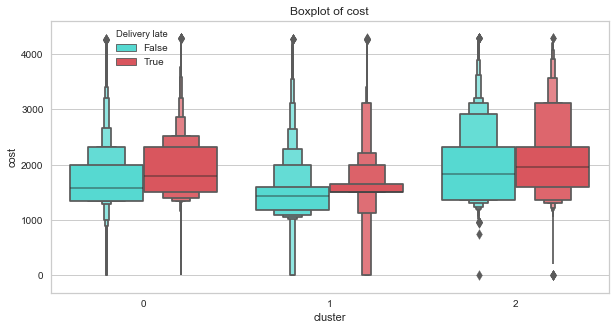

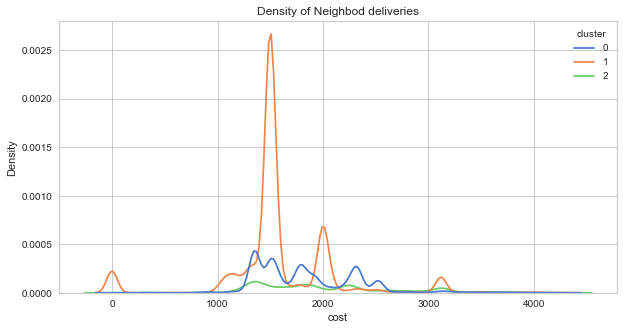

In [271]:
z_scores = stats.zscore(df['cost'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 3
df_ = df[ filtered_entries ]

plt.figure(figsize=(10,5))
plt.tight_layout()
gtg = sns.boxenplot(data=df_, x='cluster', y='cost', hue='is_late', palette=PALETTE_ALT)
gtg.set_title('Boxplot of cost')
gtg.legend_._set_loc(2)
gtg.legend_.set_bbox_to_anchor((0.1, 1))
gtg.legend_.set_title('Delivery late')

plt.figure(figsize=(10,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='cost', hue='cluster', palette='muted')
gts.set_title('Density of Neighbod deliveries')

En el boxplot podemos observar, para las tareas que no estan atrasadas, que el clsuter 1 es que tiene una mediana mas baja que el resto y su distribucion esta mucho mas concentrada en alrededor de ese valor. Para tareas atrasadas, el cluster 0 tiene una mediana mayor que el cluster 1 pero menor que el cluster 2 que presenta la mas alta y una distribucion mas distribuida en todo su rango.

En el kdeplot podemos observar como claramente el clsuter 1 presenta una altisima densidad de tareas con un costo entre los valores de 100 y 200 dolares. El cluster 0 tiene pequeñas conncetraciones entre el rango de 100 y 2000 dolares, sin embargo, es mucho menos que el clsuter 1. Finalmente el cluster 2 es el que presenta la concentracion mas baja.

Text(0.5,1,'Density of distance')

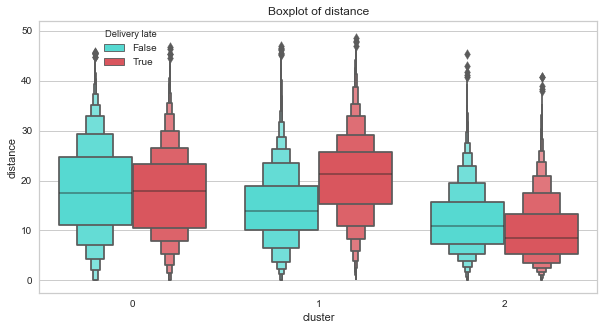

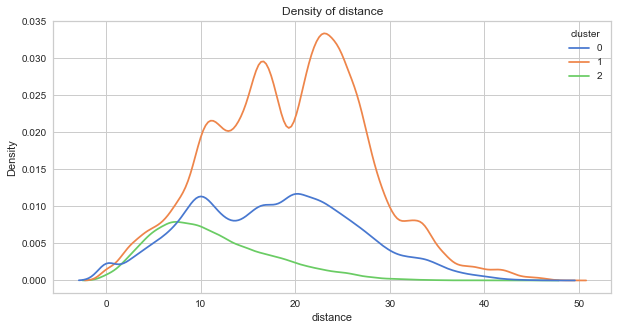

In [272]:
z_scores = stats.zscore(df['distance'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 3
df_ = df[ filtered_entries ]

plt.figure(figsize=(10,5))
plt.tight_layout()
gtg = sns.boxenplot(data=df_, x='cluster', y='distance', hue='is_late', palette=PALETTE_ALT)
gtg.set_title('Boxplot of distance')
gtg.legend_._set_loc(2)
gtg.legend_.set_bbox_to_anchor((0.1, 1))
gtg.legend_.set_title('Delivery late')

plt.figure(figsize=(10,5))
plt.tight_layout()
gts = sns.kdeplot(data=df_, x='distance', hue='cluster', palette='muted')
gts.set_title('Density of distance')

En el boxplot podemos observar que para las tareas que no estan atrasadas, el clsuter 0 tiene la mediana mas alta de distancia, le sigue el cluster 1 y por ultimo el 2. Para las tareas atrasadas, el cluster 1 es el que presenta la mediana mas alta de distancia, le sigue el clsuter 0 y por ultimo el 2.

En el kdeplot, podmeos observar como el cluster 1 es el que presenta una densidad alta de entregas con distnacias entre 10 y 30 km, el cluster 0 tiene un comportamiento similar y por ultimo el cluster 2 tiene una conentracion mas alta entre los valores de 0 y 10 km.

## Cluster 0
- Para las tareas no atrasadas su valor de entregas vecinas esta entre los valores de los clsuters 1 y 2. Para tareas atrasadas, su  valor es el mas bajo junto con el del clsuter 2.
- El costo de sus entregas tiene una concentracion mas amplia que los otros clusters. Este esta entre 1000 y 2500 (chile).
- La distancia de sus entregas esta entre los valores de los cluster 1 y 2.
## Cluster 1
- Mayor mediana de entregas vecinas para tareas atrasadas.
- Menor costo en las entregas atrasadas y su rango es muy renducido, entre 1200 y 1500 (chile).
- Mayor mediana de distancia para entregas atrasadas
El cluster 1 se caracteriza por tener tareas atrasadas con una alta cantidad de entregas vecinas, un costo mas bajo y una distancia mas alta que el resto de clsuters.
## Cluster 2
- Para tareas no atrasadas, su media esta entre la del cluster 0 y cluster 1. Para entregas atrasadas, su valor de entregas vecinas es al igual que el cluster es la mas baja.
- Para tareas no atrasadas y atrasadas, su media es la mas alta entre los otros clusters.
- Tanto para tareas no atrasadas como para atrasadas, su media es la mas baja entre los clusters.
 

In [ ]:
cluster_3 = df[ df['cluster'] == 3 ]
cluster_3[features].describe()

In [ ]:
cluster_1 = df[ df['cluster'] == 1 ]
cluster_2 = df[ df['cluster'] == 2 ]
cluster_3 = df[ df['cluster'] == 3 ]

## Josue Cobos

In [ ]:
g = sns.countplot(data=df_t, x='hight_neight', color=PALETTE_ALT[1])
g.set_xticks([0,1])

In [ ]:
#Question: Are those deliveries that are further from the economic center of Belo Horizonte those with the longest delivery delay?

In [ ]:
#calculate distance between 2 lat long points
def calculateDistance(point, anotherPoint):
    lat1, lon1 = point
    lat2, lon2 = anotherPoint 
    R = 6373.0
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance #kilometers

In [ ]:
#For this question we will assume Barreiro in the most important regional administration of Belo Horizonte
BARREIROPOINT = (-19.977, -44.0145)
def getDistanceFromA(row):
  #print(row)
  return calculateDistance(BARREIROPOINT, (row['lat'], row['long']))
  #return row #distance

In [ ]:
df['dst_to_barreiro'] = df[['lat', 'long']].apply(getDistanceFromA, axis=1)

In [ ]:
plt.figure(figsize=(15,7))
subdf = df[['dst_to_barreiro','delay_delivery']]
f2 = sns.scatterplot(x=subdf['dst_to_barreiro'], y=subdf['delay_delivery'])
#with_hue(f, df.class_weight, 8, 2)

In [ ]:
subdf.corr()

In [ ]:
#Answer: Due to the non-existent correlation between the delay of shipments (delay_delivery) and distance to Barreiro (dst_to_barreiro), we can conclude that no matter how far your order is, it does not necessarily mean that it has a longer delay time.